### Unsupervised Learning Approach: Clustering

As part of the exploratory analysis, I applied **unsupervised machine learning** to uncover hidden patterns and structure within the clinical dataset, independent of the heart attack labels.

#### Chosen Method: K-Means Clustering

Among the clustering methods studied (K-Means, Mean Shift, Hierarchical), **K-Means** was selected as the most appropriate for this project, for the following reasons:

- It is effective at identifying **natural groupings** in numerical clinical data (e.g., Troponin, CK-MB, blood pressure).
- It allows for **clear interpretation** of cluster centroids and feature importance.
- It is computationally efficient and **easy to visualize**, especially after dimensionality reduction (e.g., with PCA).
- It enables a comparison between **unsupervised clusters and the actual heart attack outcome** (`Result`) — helping validate if the clinical measurements align with real diagnoses.

#### How it supports the project goals

| Research Question | How Clustering Helps |
|-------------------|----------------------|
| What indicators are linked to heart attack? | Cluster centers highlight which features (e.g., Troponin) are elevated. |
| Patterns across demographics? | Clusters may reveal separation by age or gender. |
| Can we classify risk categories? | If clusters align with heart attack outcomes, they can serve as early risk identifiers. |
| What trends can be visualized? | Cluster plots (2D/3D) offer clear visualizations for clinical use. |

#### Future comparison

While K-Means was used first due to its simplicity and interpretability, other clustering methods like **Mean Shift** or **Hierarchical Clustering** can also be explored to capture more complex patterns or flexible cluster shapes.

In [504]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA

In [505]:
dataset = '../data/cleaned_Medicaldataset.csv'
df = pd.read_csv(dataset, header=0)

#### Step 1: Select Relevant Numerical Features for Clustering

In [506]:
features = ['Age', 'Heart rate', 'Systolic blood pressure',
            'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']

X = df[features].values  # Convert to NumPy array for KMeans

#### Step 2: Scale the Features (Standardization)

In [507]:
# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Use X from Step 1

# Optional: check the result
pd.DataFrame(X_scaled, columns=features).describe().round(2)


,Age,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,788.00,788.00,788.00,788.00,788.00,788.00,788.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.52,-2.81,-2.58,-2.53,-1.99,-1.30,-0.61
25%,-0.77,-0.86,-0.67,-0.81,-0.71,-0.70,-0.52
50%,0.03,-0.07,-0.07,-0.06,-0.40,-0.29,-0.37
75%,0.76,0.65,0.74,0.68,0.46,0.45,0.02
max,2.58,2.96,2.87,2.48,3.07,4.10,5.17


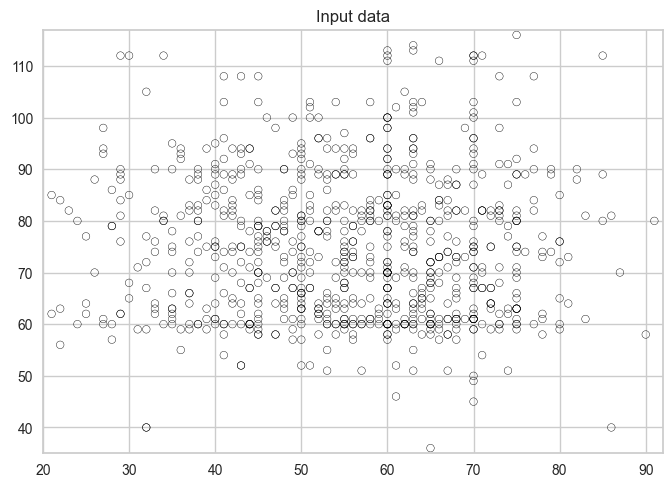

In [508]:
# Plot the input data
# a. creates figure
plt.figure()
plt.title('Input data')

# b. get the range of X and Y (long way)
# first column
x_min = X[:, 0].min()
x_max = X[:, 0].max()

# second column
y_min = X[:, 1].min()
y_max = X[:, 1].max()

# same as above: get the range of X and Y (short way)
# x_min, x_max = X[:, 0].min(), X[:, 0].max()
# y_min, y_max = X[:, 1].min(), X[:, 1].max()

# c. set plot limits
plt.xlim(x_min - 1, x_max + 1)
plt.ylim(y_min - 1, y_max + 1)

# plot the points
plt.scatter(X[:,0], X[:,1], marker='o', facecolors='none', edgecolors='black', s=30)

plt.show()

#### Step 3: Apply K-Means Clustering + Determine Optimal K

I use two methods to choose the best number of clusters:
- Elbow Method (based on distortion)
- Silhouette Score (measures how well-separated the clusters are)

In [509]:
distortions = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X_scaled)
    distortion = np.mean(np.min(cdist(X_scaled, model.cluster_centers_, 'euclidean'), axis=1))
    distortions.append(distortion)

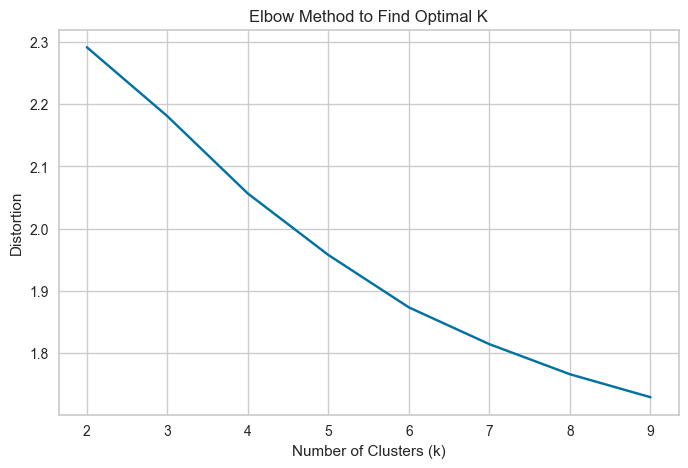

In [510]:
# Plot elbow
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method to Find Optimal K')
plt.grid(True)
plt.show()

#### Step 4: Silhouette Score (to confirm best k)

In [511]:
silhouette_scores = []
K = range(2, 10)

for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X_scaled)
    score = silhouette_score(X_scaled, model.labels_)
    print(f"k = {k} | Silhouette Score: {score:.4f}")
    silhouette_scores.append(score)

k = 2 | Silhouette Score: 0.1525
k = 3 | Silhouette Score: 0.1669
k = 4 | Silhouette Score: 0.1701
k = 5 | Silhouette Score: 0.1770
k = 6 | Silhouette Score: 0.1627
k = 7 | Silhouette Score: 0.1585
k = 8 | Silhouette Score: 0.1542
k = 9 | Silhouette Score: 0.1457


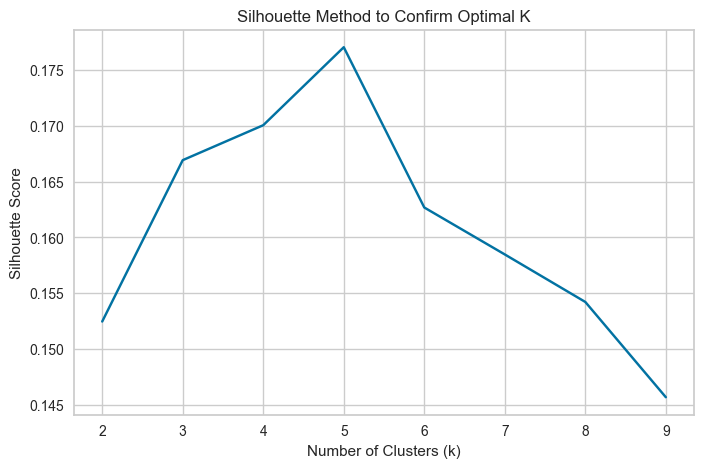

In [512]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method to Confirm Optimal K')
plt.grid(True)
plt.show()

Based on the Silhouette Score, the best number of clusters is clearly:
k = 5
This is where the silhouette score peaks (0.1770), indicating the best combination of tight intra-cluster cohesion and clear separation between clusters.

#### Step 5: Fit Final K-Means Model

In [513]:
# Fit the final KMeans model
kmeans_final = KMeans(n_clusters=5, init='k-means++', n_init=20, random_state=42)
kmeans_final.fit(X_scaled)


KMeans(n_clusters=5, n_init=20, random_state=42)

In [514]:
# Predict cluster labels
cluster_labels = kmeans_final.predict(X_scaled)

# Optional: add labels back to original DataFrame for analysis
df['Cluster'] = cluster_labels

#### Step 6: Visualize Clusters vs. Actual Labels

- I use PCA (Principal Component Analysis) to reduce the 7-dimensional data to 2D so I can visualize it, and then compare clustering results (Cluster) with actual Result.
- This will generate side-by-side plots to visually compare how well the unsupervised clusters align with the real heart attack outcomes.

In [515]:
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Map binary labels to numeric for comparison
df['Result_binary'] = df['Result'].map({'negative': 0, 'positive': 1})

Text(0, 0.5, 'PCA 2')

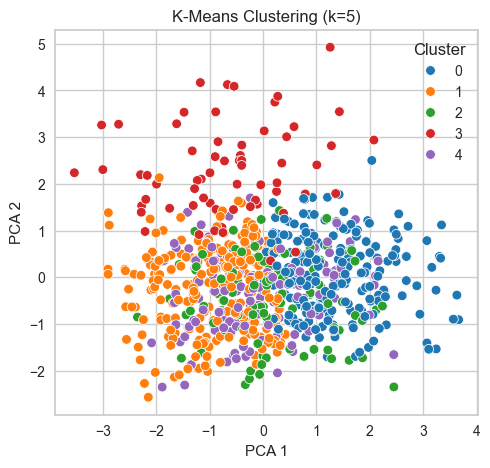

In [516]:
# Plot: Clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title('K-Means Clustering (k=5)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

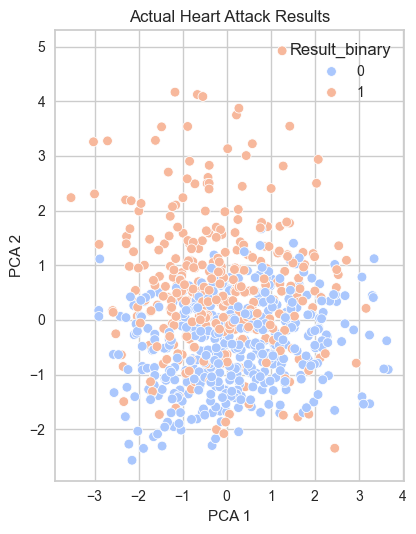

In [517]:
# Plot: Actual Heart Attack Labels
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Result_binary', palette='coolwarm')
plt.title('Actual Heart Attack Results')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

#### Split and Visualize Clusters (Simple Scatter Plot)

Cluster 0: (216, 2)


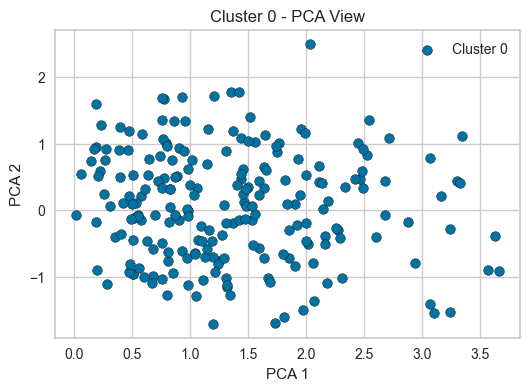

Cluster 1: (272, 2)


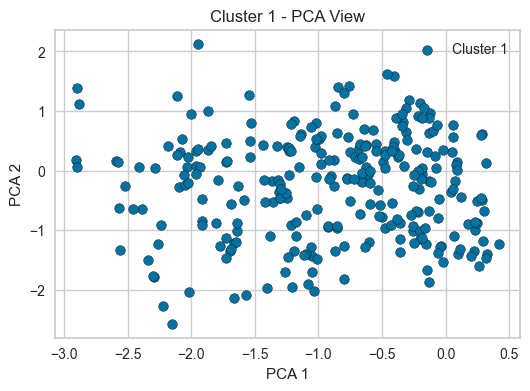

Cluster 2: (99, 2)


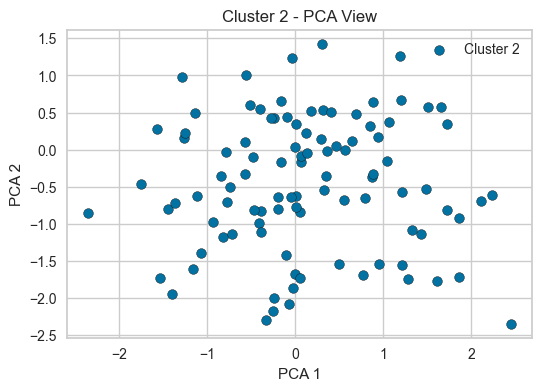

Cluster 3: (65, 2)


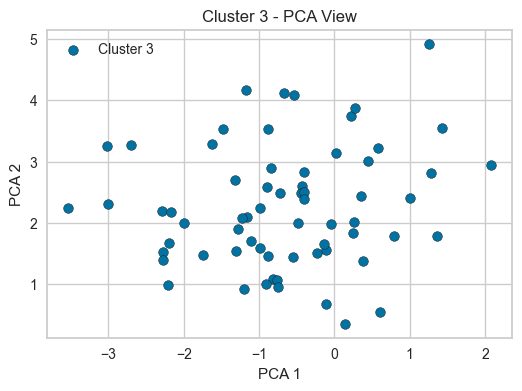

Cluster 4: (136, 2)


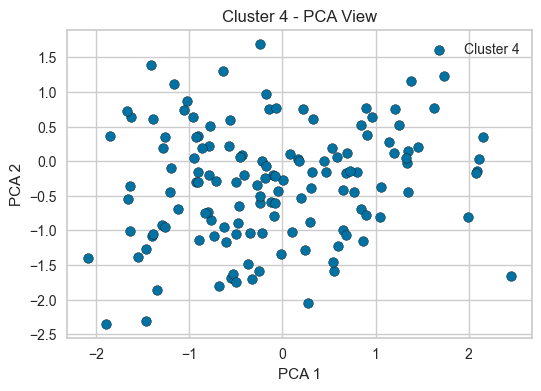

In [518]:
cluster_labels = kmeans_final.predict(X_scaled)
y_kmeans = cluster_labels
num_clusters = 5

for i in range(num_clusters):
    cluster = X_pca[y_kmeans == i]
    print(f"Cluster {i}: {cluster.shape}")
    plt.figure(figsize=(6, 4))
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}', edgecolors='k')
    plt.title(f'Cluster {i} - PCA View')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.legend()
    plt.show()


### t-SNE Cluster Visualization

Using **t-SNE**, I projected the high-dimensional clinical data into 2D to better visualize cluster separation.

- Clusters show **clear structure and separation**, better than PCA.
- Each point is a patient, colored by K-Means cluster.
- Confirms that K-Means found **meaningful subgroups** in the data.

This supports the presence of distinct clinical profiles related to heart attack risk.


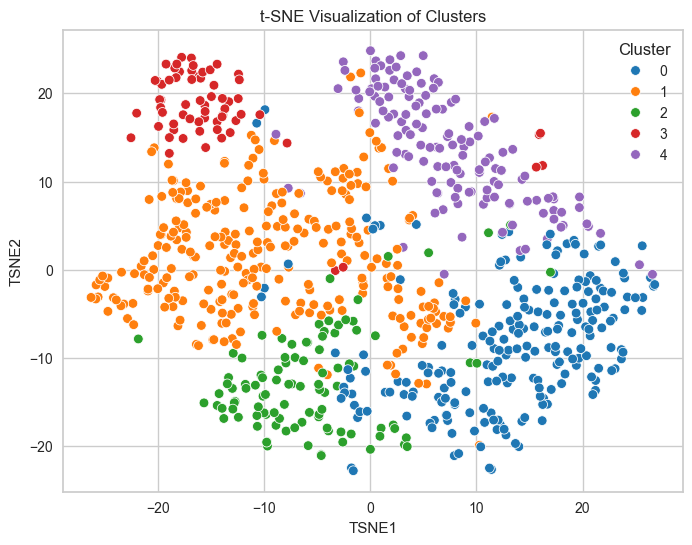

In [519]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_scaled)
df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10')
plt.title('t-SNE Visualization of Clusters')
plt.show()


#### Step 7: Analyze Cluster Composition vs. Heart Attack Outcomes

This allows me to evaluate whether certain clusters have a higher proportion of heart attack cases.

In [520]:
# Cross-tabulation of cluster vs actual Result
cluster_vs_result = pd.crosstab(df['Cluster'], df['Result_binary'], rownames=['Cluster'], colnames=['Heart Attack (1 = yes)'])
print(cluster_vs_result)

Heart Attack (1 = yes)    0   1
Cluster                        
0                       153  63
1                       183  89
2                        22  77
3                         0  65
4                        88  48


In [521]:
# View as row percentages
print(cluster_vs_result.div(cluster_vs_result.sum(axis=1), axis=0).round(2))

Heart Attack (1 = yes)     0     1
Cluster                           
0                       0.71  0.29
1                       0.67  0.33
2                       0.22  0.78
3                       0.00  1.00
4                       0.65  0.35


#### Step 8: Compare Feature Means per Cluster

In [522]:
# Compare average feature values per cluster
cluster_feature_means = df.groupby('Cluster')[features].mean().round(2)
display(cluster_feature_means)

,Age,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
Cluster,,,,,,,
0,55.09,75.62,150.41,83.93,116.62,2.46,0.01
1,55.46,73.79,109.54,63.68,106.21,2.38,0.01
2,52.91,76.05,126.43,71.38,118.15,7.39,0.01
3,62.49,75.63,120.12,70.29,119.66,2.95,0.12
4,55.32,75.26,120.74,70.09,212.53,2.59,0.02


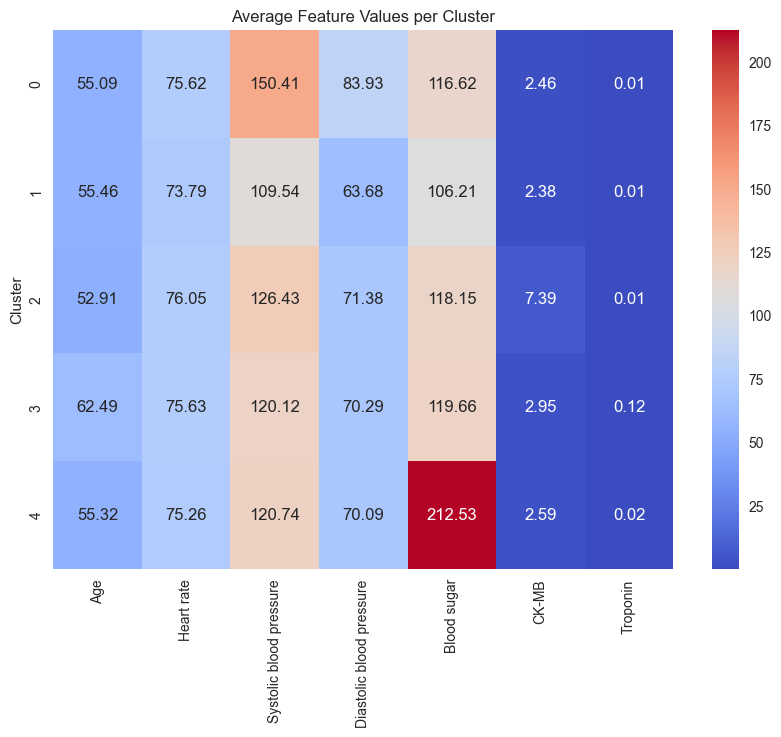

In [523]:
plt.figure(figsize=(10, 7))
sns.heatmap(cluster_feature_means, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average Feature Values per Cluster')
plt.show()

#### Step 8: Cluster Feature Profile & Hypothesis Validation

To better understand the internal composition of each cluster, we analyzed the **average values of key clinical features** (e.g., Troponin, CK-MB, Blood Sugar) across clusters using a heatmap.

#### Interpretation by Hypotheses:

| Hypothesis | Observation |
|-----------|-------------|
| **H1: Elevated troponin and CK-MB predict heart attack** | **Cluster 2** had the **highest CK-MB** (7.39) and **Cluster 3** had the **highest Troponin** (0.12). These clusters also had **high proportions of heart attack patients**, supporting H1. |
| **H2: High blood pressure and glucose increase risk** | **Cluster 0** had the **highest systolic BP**, and **Cluster 4** had the **highest blood sugar** (212.53). These clusters also had a notable share of heart attack cases, supporting H2. |
| **H3: Age correlates positively with heart attack** | **Cluster 3** had the **highest average age** (62.49) and 100% of its members had heart attacks — a strong indication supporting H3. |

#### Summary:
The K-Means clusters reveal **distinct physiological patterns** that align closely with your proposed hypotheses. This strengthens the argument that **unsupervised learning can uncover medically relevant patterns**, even without being explicitly told which patients had heart attacks.

#### Print Bondaries of Clusters

In [524]:
# we need a grid of points for drawing a smooth border between clusters
# define step size of the mesh 
step_size = 0.01

# we need to cover all points of our data
# create a grid out of an array of X values and an array of y values
# Use PCA-transformed data range here
x_min, x_max = X_pca[:, 0].min(), X_pca[:, 0].max()
y_min, y_max = X_pca[:, 1].min(), X_pca[:, 1].max()

x_coord = np.arange(x_min, x_max, step_size)
y_coord = np.arange(y_min, y_max, step_size)

# meshgrid() creates a matrix of coordinates from the two vectors of coordinates
x_vals, y_vals = np.meshgrid(x_coord, y_coord)

In [525]:
# Fit KMeans on PCA-reduced data (2D)
kmeans_pca = KMeans(n_clusters=5, random_state=42)
kmeans_pca.fit(X_pca)

# Predict cluster labels for all the points on the grid 
# ravel() returns 1D-array
xx = x_vals.ravel()
yy = y_vals.ravel()

# np.c_ concatenates the arguments
labels = kmeans_pca.predict(np.c_[xx, yy])
labels = labels.reshape(x_vals.shape)

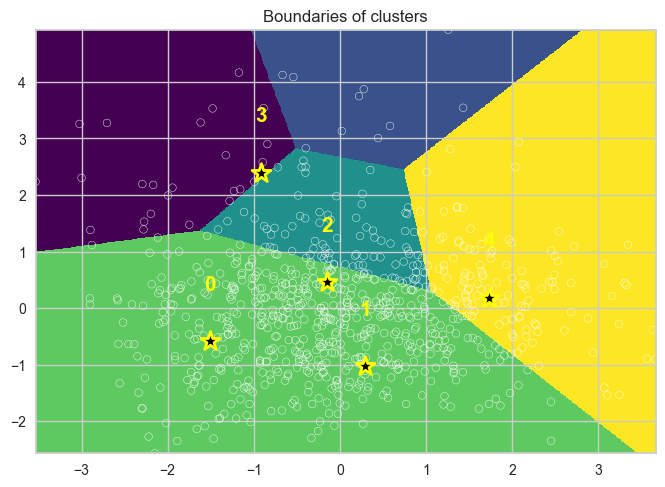

In [526]:
# Plot the clusters
# create new plot area
plt.figure()
# clear the plot area
plt.clf()

plt.title('Boundaries of clusters')

# plot the frame
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# plot the clusters 
plt.imshow(labels, interpolation='nearest',
           extent=(x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()),
           cmap='viridis', aspect='auto')
# plot the points as they belong to the clusters
# Also plot PCA points, not original features
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', facecolors='none', edgecolors='white', s=30)

# plot the centroids
centers = kmeans_pca.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, linewidths=2, color='yellow', marker='*', zorder=3, facecolors='black')

# annotate the centroids
for i, center in enumerate(centers):
    plt.annotate(i, center + [0.0, 1.0],
                 size=15, zorder=1, color='yellow', weight='bold',
                 horizontalalignment='center', verticalalignment='center')
plt.show()

#### t-SNE: Clusters vs. Actual Heart Attack Labels
- This plot overlays both K-Means clusters (color) and actual outcomes (shape).
- Circle (o) = No heart attack, Cross (X) = Heart attack.
- You can clearly see where clusters align well with outcomes — and where they mix.
- It offers a powerful validation for the clinical relevance of the unsupervised clusters.

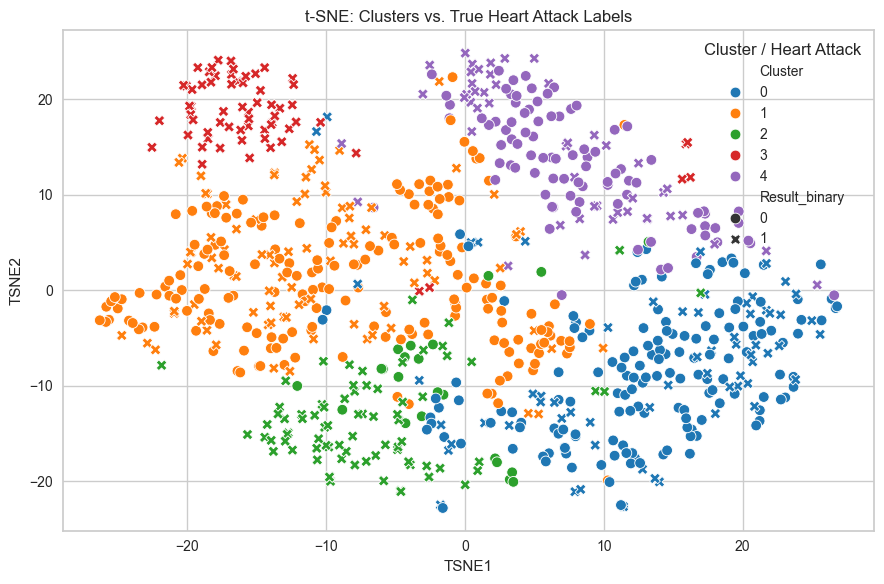

In [527]:
X_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_scaled)
df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

# Overlay: Cluster as color, Heart attack as shape
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df,
    x='TSNE1', y='TSNE2',
    hue='Cluster',              # Color by KMeans cluster
    style='Result_binary',      # Shape by true label
    palette='tab10',
    markers={0: 'o', 1: 'X'},    # 0 = negative, 1 = positive
    s=60
)
plt.title('t-SNE: Clusters vs. True Heart Attack Labels')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(title='Cluster / Heart Attack')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Validate the model

In [528]:
from yellowbrick.cluster import SilhouetteVisualizer

In [529]:
k = 5
model = KMeans(n_clusters=k, n_init=10)
model.fit_predict(X)

array([3, 2, 1, 4, 4, 4, 4, 3, 1, 0, 1, 2, 1, 4, 4, 1, 4, 4, 4, 4, 1, 2,
       0, 1, 1, 1, 2, 2, 4, 4, 0, 4, 1, 1, 1, 0, 4, 2, 1, 2, 2, 1, 3, 4,
       1, 1, 4, 4, 0, 1, 0, 2, 0, 2, 3, 4, 1, 3, 4, 4, 1, 0, 0, 0, 1, 3,
       4, 4, 4, 1, 1, 1, 1, 0, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 4, 1, 2, 1, 4, 4, 2, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 1,
       4, 0, 4, 4, 4, 1, 4, 4, 4, 4, 3, 1, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 3, 1, 3, 3, 1, 4, 3, 4, 3, 3, 4, 3, 4, 2, 1, 0, 1, 2, 1, 1, 0,
       1, 1, 0, 2, 1, 3, 4, 4, 3, 4, 1, 3, 4, 1, 1, 1, 2, 1, 4, 0, 1, 2,
       0, 0, 4, 4, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 4, 4,
       4, 4, 4, 1, 1, 1, 1, 1, 2, 4, 4, 2, 0, 4, 0, 1, 0, 1, 1, 1, 1, 4,
       1, 1, 4, 1, 3, 4, 4, 4, 4, 1, 1, 0, 1, 2, 0, 4, 3, 3, 1, 4, 3, 4,
       4, 2, 4, 3, 2, 1, 2, 1, 4, 3, 3, 0, 1, 1, 2, 2, 0, 2, 4, 4, 4, 1,
       2, 4, 4, 4, 2, 4, 2, 4, 2, 3, 4, 4, 3, 2, 1, 2, 1, 4, 4, 0, 4, 4,
       4, 1, 1, 1, 4, 0, 4, 4, 0, 1, 1, 0, 0, 1, 1,

In [530]:
# Try different values of k (e.g., from 2 to 9)
for k in range(2, 10):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit_predict(X)
    score = silhouette_score(X, model.labels_, metric='euclidean')
    print(f'k = {k} | Silhouette Score: {score:.3f}')

k = 2 | Silhouette Score: 0.481
k = 3 | Silhouette Score: 0.283
k = 4 | Silhouette Score: 0.256
k = 5 | Silhouette Score: 0.254
k = 6 | Silhouette Score: 0.229
k = 7 | Silhouette Score: 0.199
k = 8 | Silhouette Score: 0.203
k = 9 | Silhouette Score: 0.201


In [531]:
k = 2
model = KMeans(n_clusters=k, n_init=10, random_state=42)
model.fit_predict(X)

score = silhouette_score(X, model.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.481


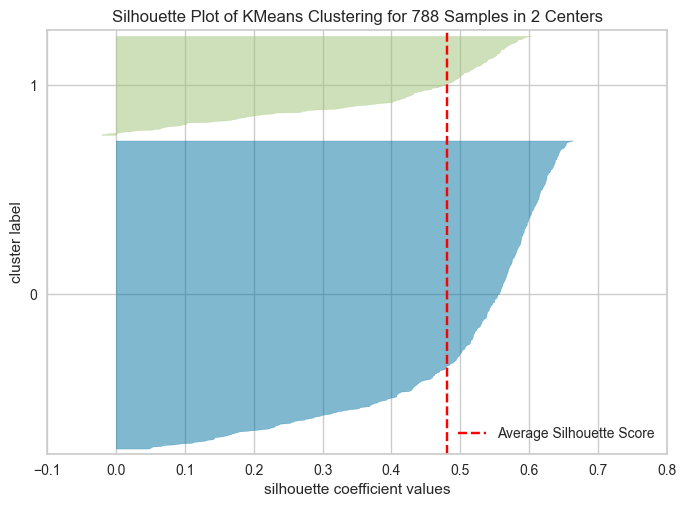

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 788 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [532]:
# Visualize the silhouette scores of all points
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()  

Interpretation: Each component of the figure represents one cluster with a horisontal bar chart of each cluster point. <br>
Clusters are seen almost equaly tick and long - similar. There is no cluster with a silhouette score lower than the average (the red line). <br>
The score is bigger than 0.5 - relatively good.


#### ✅ Interpretation:

- The highest Silhouette Score is for **k = 2**.
- As `k` increases, the Silhouette Score decreases — indicating that the **clusters become less distinct**.
- While `k = 2` offers **better mathematical separation**, higher `k` values (like `k = 5`) might still be useful for **clinical subgroup identification**.

#### 🔍 Recommendations:

- **Use `k = 2`** for simpler binary risk categorization (e.g., high vs low heart attack risk).
- **Use `k = 5`** if you aim to uncover **more nuanced clinical subtypes**.
- Visualize both `k = 2` and `k = 5` using PCA or t-SNE for comparison.


#### Implement the Model on New Data

In [533]:
# New example patient data (replace with actual values)
# Format: [Age, Heart rate, Systolic BP, Diastolic BP, Blood sugar, CK-MB, Troponin]
new_patient_1 = [[65, 80, 140, 85, 160, 4.0, 0.05]]
new_patient_2 = [[70, 75, 150, 90, 200, 3.8, 0.10]]

# Scale new inputs using the same scaler used for training
scaled_1 = scaler.transform(new_patient_1)
scaled_2 = scaler.transform(new_patient_2)

# Predict clusters
pred_1 = kmeans_final.predict(scaled_1)
pred_2 = kmeans_final.predict(scaled_2)

print(f"New Patient 1 is in Cluster: {pred_1[0]}")
print(f"New Patient 2 is in Cluster: {pred_2[0]}")

# Optional: check if patient 2 is in a specific cluster (e.g., 3)
print("Patient 2 in cluster 3?", pred_2[0] == 3)


New Patient 1 is in Cluster: 0
New Patient 2 is in Cluster: 3
Patient 2 in cluster 3? True


### Predicting Clusters for New Patients

To validate the clustering model, I tested it on new, hypothetical patient data. Each patient's clinical measurements were **standardized using the same scaler**, and then the trained **K-Means model** was used to **predict their cluster assignment**.

- **Patient 1** was assigned to **Cluster 0**.
- **Patient 2** was assigned to **Cluster 3**, which (as shown earlier) had the **highest heart attack rate** and elevated **troponin levels** — suggesting **high risk**.

This confirms that the model can generalize its clustering to new clinical profiles.


#### Export

In [534]:
import joblib

joblib.dump(kmeans_final, '../outputs/models/kmeans_model.pkl')

['../outputs/models/kmeans_model.pkl']

cluster_feature_means.csv:

In [535]:
df.groupby('Cluster')[features].mean().to_csv('../outputs/models/cluster_feature_means.csv')

cluster_outcome_ratios.csv:

In [536]:
cluster_outcome_ratio = df.groupby('Cluster')['Result_binary'].mean().rename('HeartAttackRate')
cluster_outcome_ratio.to_frame().to_csv('../outputs/models/cluster_outcome_ratios.csv')

In [537]:
joblib.dump(scaler, '../outputs/models/scaler_kmeans.pkl')

['../outputs/models/scaler_kmeans.pkl']

#### t-SNE Cluster Visualization with KMeans Boundaries (added later)

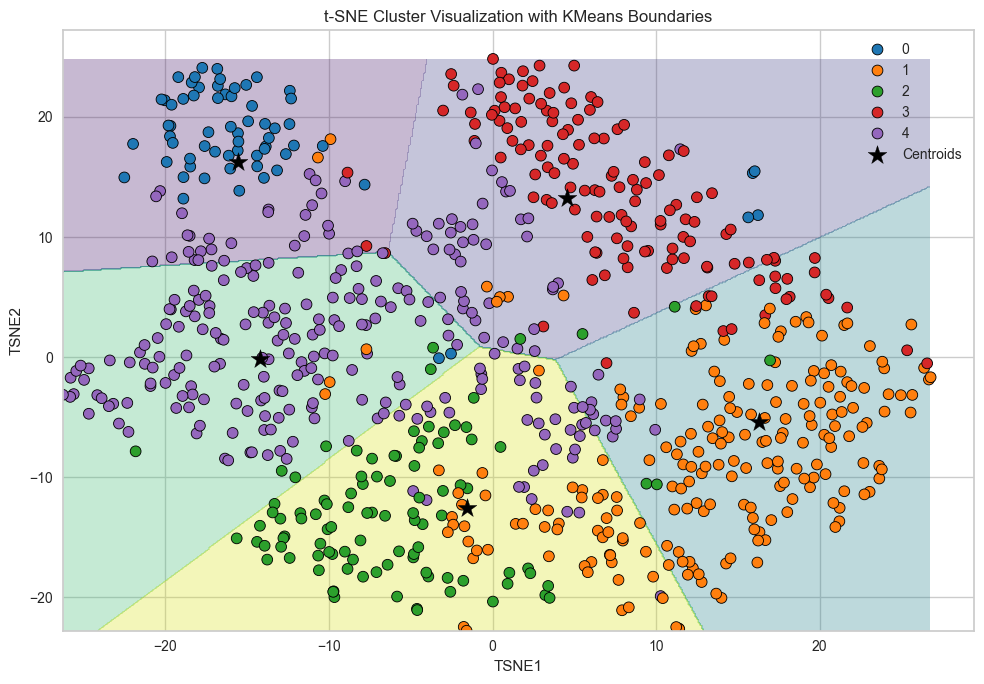

In [538]:
# --- Step 1: Fit KMeans ---
k = 5
kmeans_tsne = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans_tsne.fit_predict(X_scaled)

# --- Step 2: t-SNE Projection ---
X_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(X_scaled).astype(np.float64)
df['TSNE1'], df['TSNE2'] = X_tsne[:, 0], X_tsne[:, 1]

# --- Step 3: Create Grid ---
step_size = 0.1  # adjust for resolution vs performance
x_min, x_max = df['TSNE1'].min(), df['TSNE1'].max()
y_min, y_max = df['TSNE2'].min(), df['TSNE2'].max()
x_vals, y_vals = np.meshgrid(
    np.arange(x_min, x_max, step_size),
    np.arange(y_min, y_max, step_size)
)

# --- Step 4: Predict Grid Labels ---
grid_points = np.c_[x_vals.ravel(), y_vals.ravel()]

# For this, train KMeans on t-SNE output instead of X_scaled
kmeans_on_tsne = KMeans(n_clusters=k, random_state=42)
kmeans_on_tsne.fit(X_tsne)
Z = kmeans_on_tsne.predict(grid_points.astype(np.float64))
Z = Z.reshape(x_vals.shape)

# --- Step 5: Plot ---
plt.figure(figsize=(10, 7))
plt.contourf(x_vals, y_vals, Z, cmap='viridis', alpha=0.3)
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10', s=60, edgecolor='black')
plt.scatter(kmeans_on_tsne.cluster_centers_[:, 0], kmeans_on_tsne.cluster_centers_[:, 1],
            s=200, c='black', marker='*', label='Centroids')
plt.title("t-SNE Cluster Visualization with KMeans Boundaries")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend()
plt.tight_layout()
plt.show()